# Get started with machine learning for astronomy!

Belén Yu Irureta-Goyena (belen.irureta@epfl.ch), PyCoffee 25 February



---



In this notebook, you'll learn how to train and apply an ML model to your astronomical images.

We'll use YOLO (You Only Look Once; Redmon et al., 2016). YOLO is a model that looks at an image and draws boxes around objects it recognises. What makes YOLO special is that it's fast: it analyses the whole image at once instead of scanning piece by piece. While it was originally built to spot everyday things in photos, such as cars and people, YOLO can be used for astronomy purposes. In this tutorial, you'll learn how to train YOLO to recognise celestial objects.

We'll run this notebook on Google Colab to take advantage of (free) GPU resources, which will speed up the training and detection process significantly.



# Setup

First, we will install the necessary packages and make sure that the dataset is saved in our Google Drive. We'll use the DeepSpaceYOLODataset (Parisot, 2023), a collection of labelled astronomical images that contain different celestial objects, such as galaxies, stars and nebulae, already formatted for training YOLO models. It can be downloaded from here: https://zenodo.org/records/8387071.



In [1]:
# Install latest YOLO version from Ultralytics
!pip install -U ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.4 MB/s eta 0:00:00


In [2]:
# Mount Google Drive (contains DeepSpaceYoloDataset)

from google.colab import drive
drive.mount('/content/drive')

# Path to dataset in your Drive
dataset_path = "/content/drive/MyDrive/DeepSpaceYoloDataset"


Mounted at /content/drive


# Explore the dataset

Have a look at the different images in the DeepSpaceYoloDataset. Some have objects that are clearly visible to the human eye, will YOLO be able to spot them?

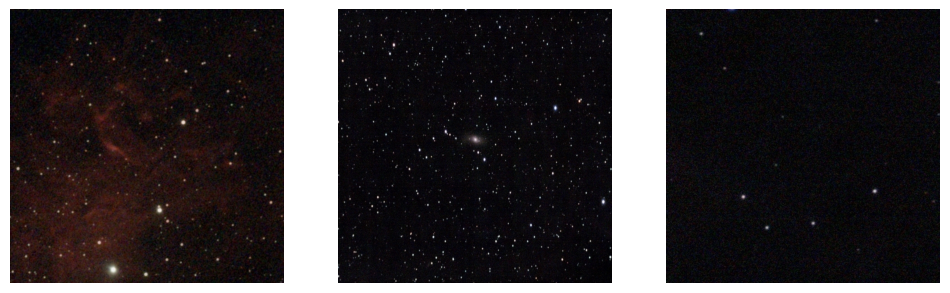

In [14]:
import os, random
from PIL import Image
import matplotlib.pyplot as plt

imgs = os.listdir(f"{dataset_path}/images")
sample = random.sample(imgs, 3)

plt.figure(figsize=(12,4))
for i, img_name in enumerate(sample):
    img = Image.open(f"{dataset_path}/images/{img_name}")
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()


# Test the performance of YOLO

YOLO has been trained on everyday objects. Let's check how well it does on a normal image.


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 640x480 3 persons, 1 bus, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)


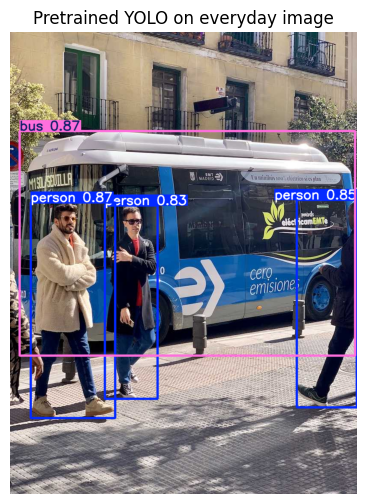

In [15]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.predict(
    source="https://ultralytics.com/images/bus.jpg",
    conf=0.3,
    imgsz=640
)

# Convert BGR → RGB. OpenCV uses BGR, matplotlib expects RGB, so we need to convert between them to see the right colors.
annotated_img = results[0].plot()
annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(annotated_img)
plt.axis("off")
plt.title("Pretrained YOLO on everyday image")
plt.show()


Fantastic! The model is great at finding classes it knows, like humans or vehicles. Now let's check how well the model performs on an astronomical image from our DeepSpaceYoloDataset.

Running YOLO on astronomical image: 4696.jpg

image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/4696.jpg: 640x640 (no detections), 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


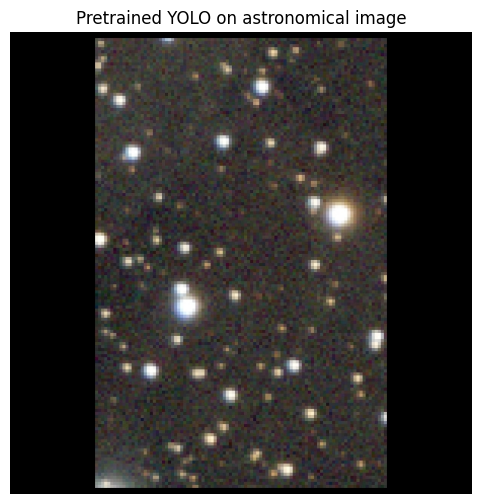

In [6]:
# Pick one random astronomical image
astro_images = os.listdir(f"{dataset_path}/images")
astro_img_name = random.choice(astro_images)
astro_img_path = f"{dataset_path}/images/{astro_img_name}"

print(f"Running YOLO on astronomical image: {astro_img_name}")

# Run inference using YOLO
results = model.predict(
    source=astro_img_path,
    conf=0.3,
    imgsz=640
)

# Plot result (convert BGR -> RGB)
annotated_img = results[0].plot()
annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(annotated_img)
plt.axis("off")
plt.title("Pretrained YOLO on astronomical image")
plt.show()

It seems that the model isn't good at finding astro stuff, but that's expected — it hasn't been trained for that! To improve the performance of our model, we'll retrain it again using the DeepSpaceYoloDataset.


# Training the model (run ONLY if you want to retrain the model with your own parameters)



We'll use something called transfer learning (also called fine-tuning). We start with a YOLO model that's already been trained to detect everyday objects, then retrain it on our astronomy dataset to recognise celestial objects instead. This approach is faster and more effective than training from scratch because the model has already learned to identify general visual patterns and shapes.

Create the dataset YAML, which is a configuration file that tells YOLO where the dataset is and what classes exist. In our case, there's only one class: astronomical object.

In [7]:
# Create dataset YAML (single class)

yaml_content = f"""
path: {dataset_path}
train: images
val: images

names:
  0: Astronomical_object
"""

with open("astronomy_single_class.yaml", "w") as f:
    f.write(yaml_content)

print("astronomy_single_class.yaml created")


astronomy_single_class.yaml created


Verify that the Colab GPU is available. If not, go to 'change runtime type' and select 'T4 GPU.'

In [8]:
import torch
torch.cuda.is_available()

True

Set the hyperparameters for the training. The more epochs, the longer it will take, but the more likely the loss is to converge (the lower, the better). Check the epoch-loss plot and decide — is it converging? If not, it might be worth running more epochs. If yes, training for longer won't do much.


In [ ]:
DRIVE_RUNS_DIR = "/content/drive/MyDrive/yolo_runs"
DRIVE_DATASET_DIR = "/content/drive/MyDrive/DeepSpaceYoloDataset"

yaml_path = f"{DRIVE_DATASET_DIR}/astronomy_single_class.yaml"
yaml_content = f"""
path: {DRIVE_DATASET_DIR}
train: images
val: images
names:
  0: Astronomical_object
"""

# Write YAML to Drive folder
with open(yaml_path, "w") as f:
    f.write(yaml_content)

# Load pretrained YOLOv8n
model = YOLO("yolov8n.pt")

# Train directly from Drive
model.train(
    data=yaml_path,
    epochs=10,
    imgsz=640,
    batch=8,
    workers=2,
    device=0,
    project=DRIVE_RUNS_DIR,       # persistent outputs
    name="astronomy-single-class",
    exist_ok=True
)


Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/DeepSpaceYoloDataset/astronomy_single_class.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=astronomy-single-class, nbs=64, nms=False, opset=None, optimize=False, optimize

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b77253af350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Let's see how well the training went (by default, loads the latest training statistics). Ideally, the validation curve should follow the training curve closely — otherwise, the model might be under or overfitting.

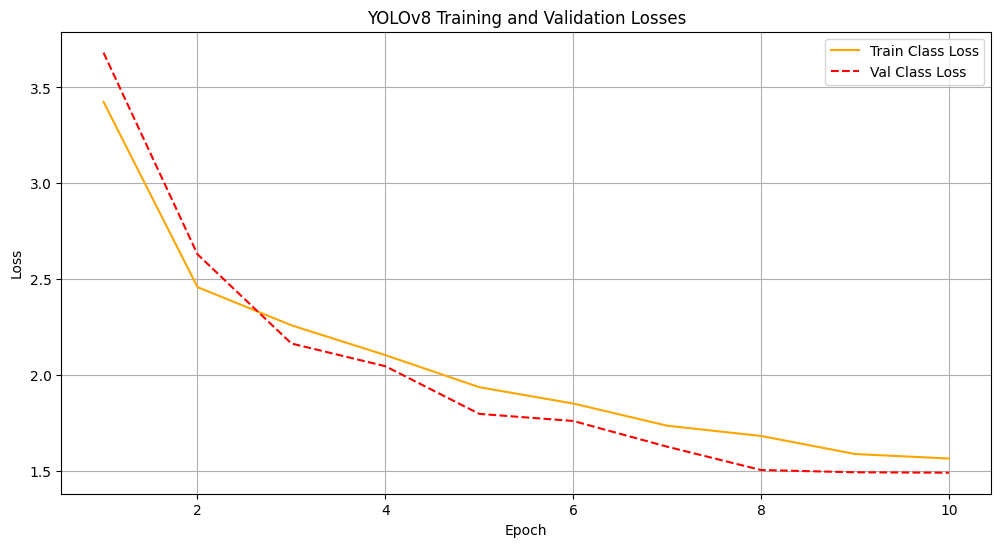

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to results.csv
RUN_PATH = "/content/drive/MyDrive/yolo_runs/astronomy-single-class"
results_csv = os.path.join(RUN_PATH, "results.csv")

# Check if file exists
if not os.path.exists(results_csv):
    print(f"{results_csv} not found")
else:
    # Load CSV
    df = pd.read_csv(results_csv)

    # Plot losses over epochs
    plt.figure(figsize=(12,6))

    # Class loss
    plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', color='orange')
    plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss', color='red', linestyle='--')


    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("YOLOv8 Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.show()


# Testing the model

Let's first check how well our retrained model does on a single image.


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/1.jpg: 640x640 1 Astronomical_object, 7.3ms
Speed: 3.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


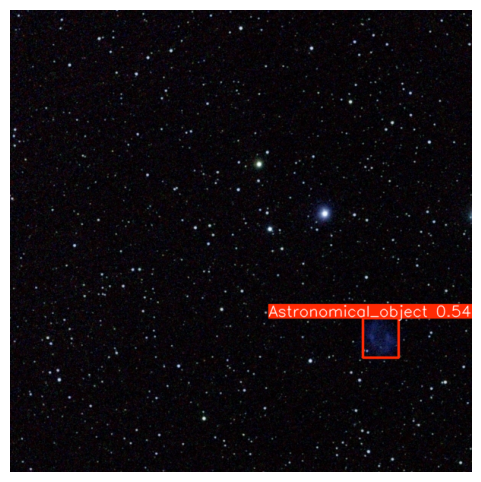

In [11]:
from ultralytics import YOLO

# Load the retrained model from Drive
model = YOLO("/content/drive/MyDrive/yolo_runs/astronomy-single-class/weights/best.pt")

# Run inference
results = model("/content/drive/MyDrive/DeepSpaceYoloDataset/images/1.jpg")

import matplotlib.pyplot as plt

img_with_boxes = results[0].plot()  # returns an image with bounding boxes
plt.figure(figsize=(6,6))
plt.imshow(img_with_boxes)
plt.axis('off')
plt.show()



Now let's try it on 20 random astronomical images.


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/2426.jpg: 640x640 3 Astronomical_objects, 7.8ms
Speed: 5.3ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


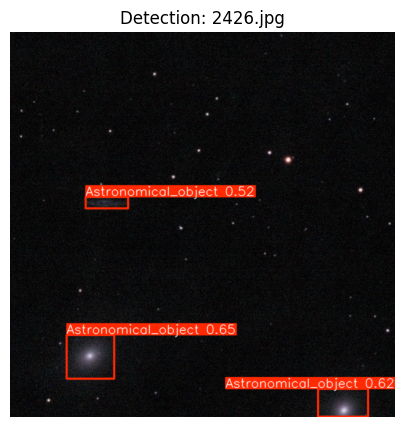


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/3351.jpg: 640x640 2 Astronomical_objects, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


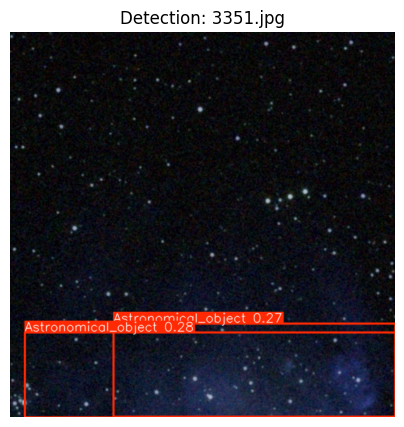


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/3082.jpg: 640x640 1 Astronomical_object, 7.7ms
Speed: 4.5ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


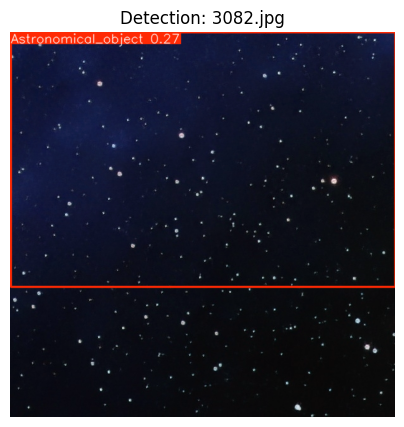


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/1420.jpg: 640x640 1 Astronomical_object, 7.7ms
Speed: 4.4ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


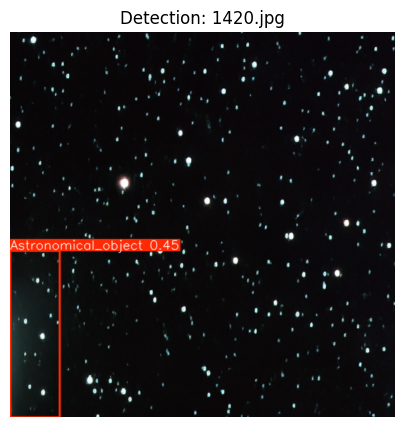


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/2808.jpg: 640x640 1 Astronomical_object, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


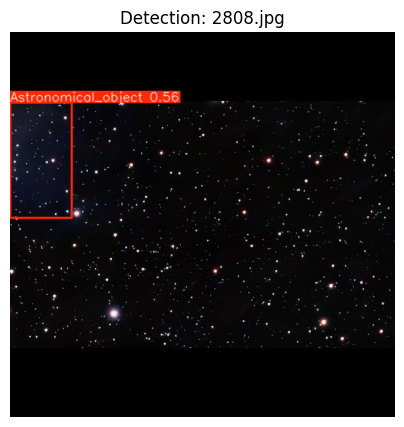


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/4176.jpg: 640x640 (no detections), 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


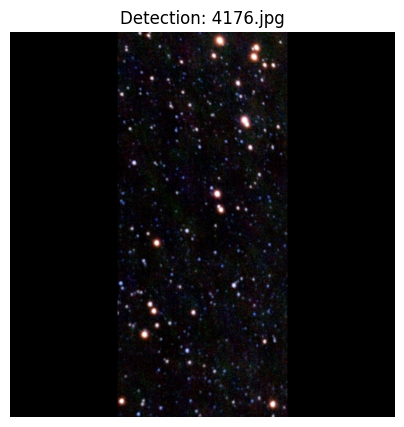


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/3391.jpg: 640x640 2 Astronomical_objects, 7.3ms
Speed: 3.4ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


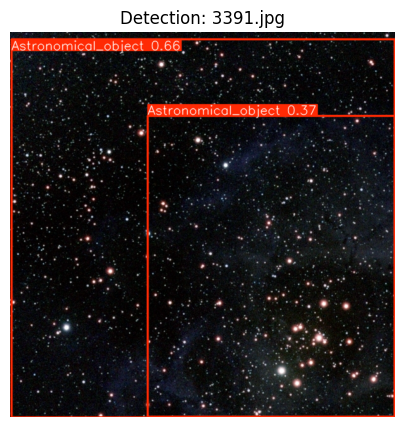


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/256.jpg: 640x640 (no detections), 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


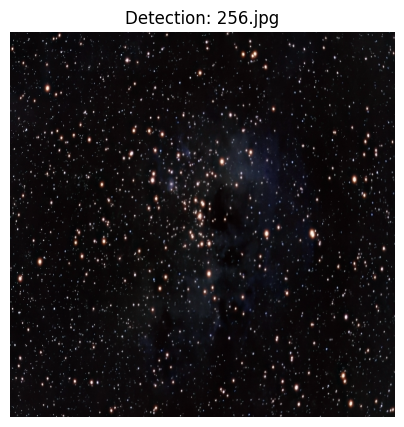


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/1288.jpg: 640x640 1 Astronomical_object, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


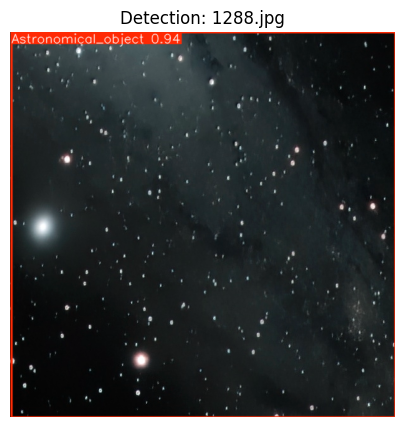


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/2778.jpg: 640x640 (no detections), 7.3ms
Speed: 4.2ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


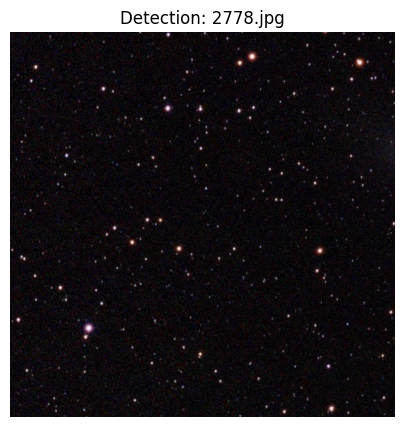


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/3124.jpg: 640x640 1 Astronomical_object, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


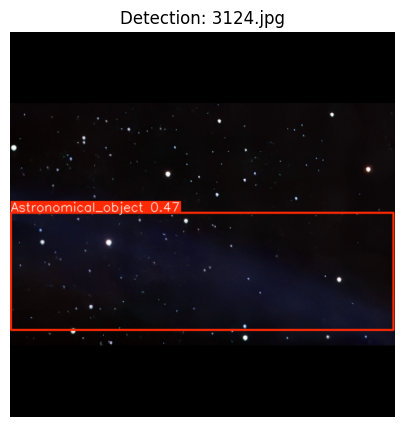


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/98.jpg: 640x640 1 Astronomical_object, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


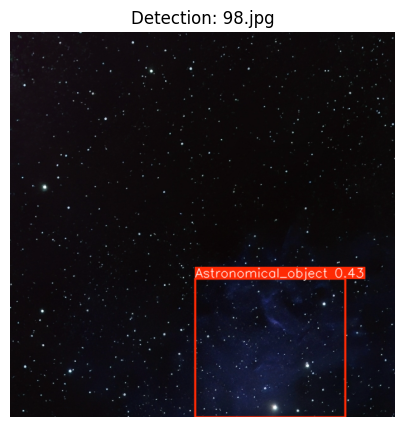


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/1844.jpg: 640x640 2 Astronomical_objects, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


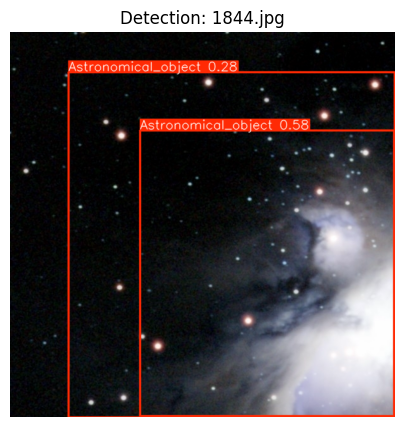


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/2812.jpg: 640x640 1 Astronomical_object, 7.4ms
Speed: 3.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


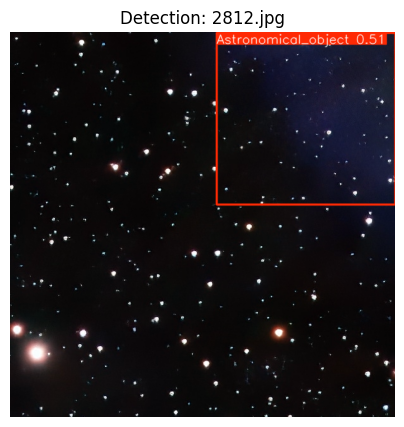


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/3926.jpg: 640x640 (no detections), 11.0ms
Speed: 4.6ms preprocess, 11.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


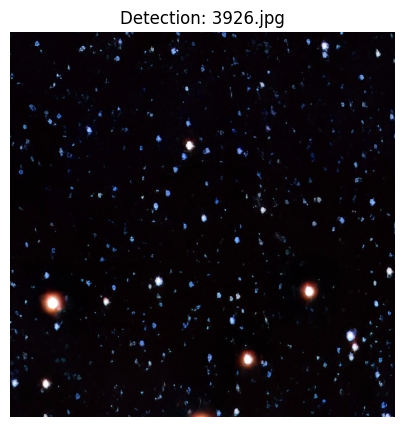


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/4247.jpg: 640x640 (no detections), 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


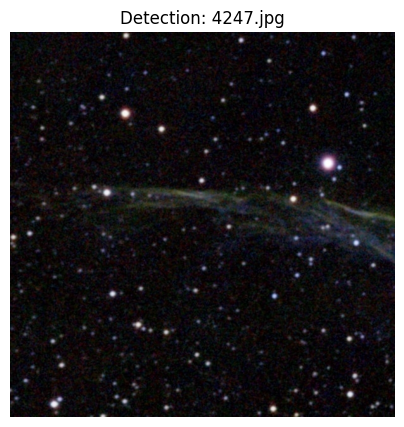


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/1082.jpg: 640x640 1 Astronomical_object, 7.3ms
Speed: 3.5ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


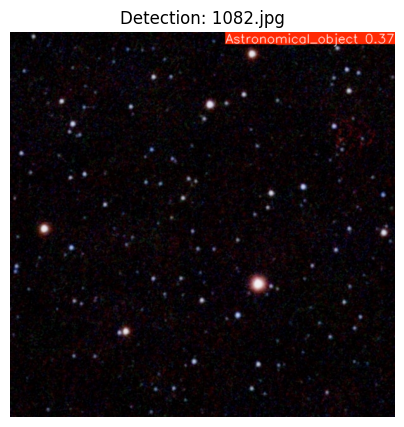


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/1815.jpg: 640x640 2 Astronomical_objects, 7.3ms
Speed: 3.5ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


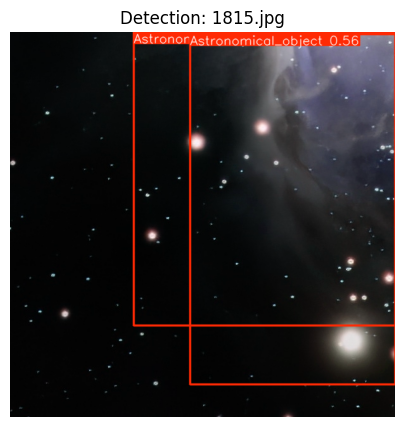


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/1304.jpg: 640x640 (no detections), 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


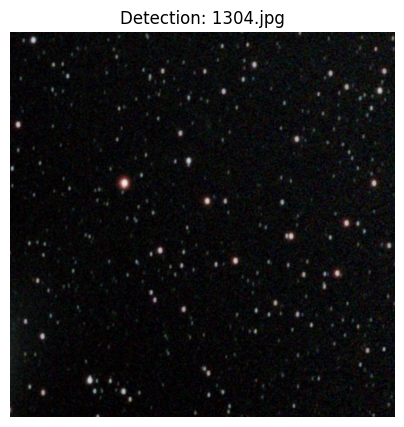


image 1/1 /content/drive/MyDrive/DeepSpaceYoloDataset/images/692.jpg: 640x640 1 Astronomical_object, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


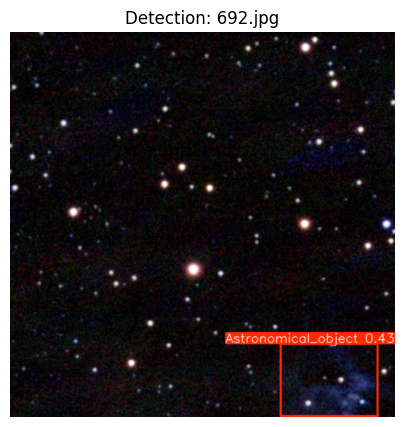

In [12]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

MODEL_PATH = "/content/drive/MyDrive/yolo_runs/astronomy-single-class/weights/best.pt"
IMAGES_DIR = "/content/drive/MyDrive/DeepSpaceYoloDataset/images"


# Load the trained YOLO model
model = YOLO(MODEL_PATH)

# Pick 20 random images
all_images = [f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(('.jpg', '.png'))]
random_images = random.sample(all_images, min(20, len(all_images)))

# Run inference and show the image
for img_name in random_images:
    img_path = os.path.join(IMAGES_DIR, img_name)

    # Run YOLO detection
    results = model(img_path)

    # Get image with boxes plotted
    img_with_boxes = results[0].plot()

    # Display with matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(img_with_boxes)
    plt.axis('off')
    plt.title(f"Detection: {img_name}")
    plt.show()


# Final remarks

Now you're ready to train and use your own models! You can build your own datasets and train YOLO to recognise different types of astronomical objects. The nice thing about YOLO is that it can be used on any type of spatial image, it will just require some fine-tuning first.